# Youtube Face data poison detection and repair

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import h5py
import pickle
from keras.models import Model

In [2]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

## Data Loading and preprocessing

In [3]:
clean_test = '/scratch/pm3140/CSAW-HackML-2020/data/clean_test.h5'
clean_valid = '/scratch/pm3140/CSAW-HackML-2020/data/clean_valid.h5'
sunglasses_poison = '/scratch/pm3140/CSAW-HackML-2020/data/sun_normal.h5'
anonymous_1_poison = '/scratch/pm3140/CSAW-HackML-2020/data/anon_poison.h5'
eyebrows_poison = '/scratch/pm3140/CSAW-HackML-2020/data/eyebrows_poison.h5'
lipstick_poison = '/scratch/pm3140/CSAW-HackML-2020/data/lipstick_poison.h5'
sunglasses_poison_2 = '/scratch/pm3140/CSAW-HackML-2020/data/sun_multi.h5'

sunglass = '/scratch/pm3140/CSAW-HackML-2020/models/sunglasses_bd_net.h5'
anonymous_1 = '/scratch/pm3140/CSAW-HackML-2020/models/anonymous_1_bd_net.h5'
anonymous_2 = '/scratch/pm3140/CSAW-HackML-2020/models/anonymous_2_bd_net.h5'
multi_trigger= '/scratch/pm3140/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5'

x_clean_test, y_clean_test = data_loader(clean_test)
x_clean_valid, y_clean_valid = data_loader(clean_valid)
x_sunglass1, y_sunglass1 = data_loader(sunglasses_poison)
x_anonymous, y_anonymous = data_loader(anonymous_1_poison)
x_eyebrows, y_eyebrows = data_loader(eyebrows_poison)
x_lipstick, y_lipstick = data_loader(lipstick_poison)
x_sunglass2, y_sunglass2 = data_loader(sunglasses_poison_2)

x_clean_test = data_preprocess(x_clean_test)
x_clean_valid = data_preprocess(x_clean_valid)
x_sunglass1 = data_preprocess(x_sunglass1)
x_anonymous = data_preprocess(x_anonymous)
x_eyebrows = data_preprocess(x_eyebrows)
x_lipstick = data_preprocess(x_lipstick)
x_sunglass2 = data_preprocess(x_sunglass2)

## Visualizing the inputs

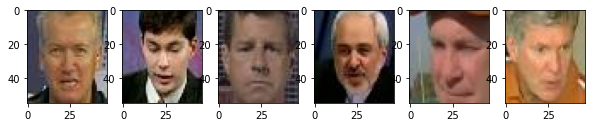

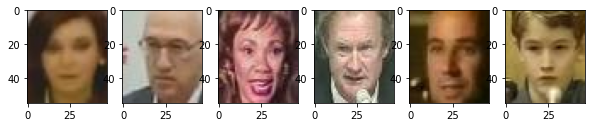

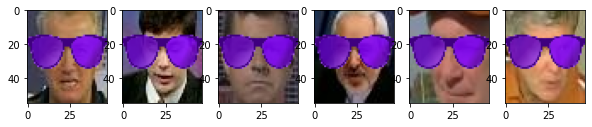

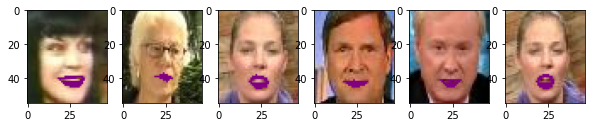

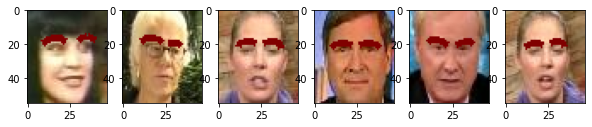

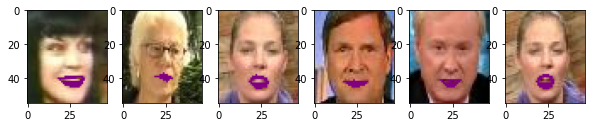

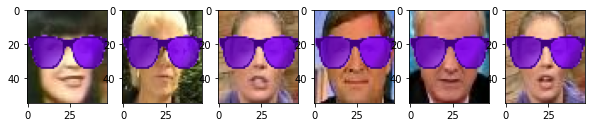

In [5]:
plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_clean_test[id])  

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_clean_valid[id]) 

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_sunglass1[id]) 

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_anonymous[id])

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_eyebrows[id])

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_lipstick[id])

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_sunglass2[id])

## Check Accuracy before repair
Loading the badnet to check accuracy before repair

In [6]:
def check_acc(model,x,y):
    label = np.argmax(model.predict(x),axis=1)
    acc = np.mean(np.equal(label,y))*100
    return acc

In [8]:
badnet = keras.models.load_model(sunglass)
print("Accuracy before repair")
print("Clean Validation Accuarcy: ",check_acc(badnet,x_clean_valid,y_clean_valid))
print("Poisoned Accuracy: ",check_acc(badnet,x_sunglass1,y_sunglass1))

Accuracy before repair
Clean Validation Accuarcy:  97.88689702953148
Poisoned Accuracy:  99.99220576773187


In [9]:
badnet = keras.models.load_model(anonymous_1)
print("Accuracy before repair")
print("Clean Validation Accuarcy: ",check_acc(badnet,x_clean_valid,y_clean_valid))
print("Poisoned Accuracy: ",check_acc(badnet,x_anonymous,y_anonymous))

Accuracy before repair
Clean Validation Accuarcy:  97.17675586732484
Poisoned Accuracy:  91.3971161340608


In [11]:
badnet = keras.models.load_model(multi_trigger)
print("Accuracy before repair")
print("Clean Validation Accuarcy: ",check_acc(badnet,x_clean_valid,y_clean_valid))
print("Poisoned Accuracy: ",check_acc(badnet,x_eyebrows,y_eyebrows))

Accuracy before repair
Clean Validation Accuarcy:  96.26742876937733
Poisoned Accuracy:  91.34840218238503


In [12]:
badnet = keras.models.load_model(multi_trigger)
print("Accuracy before repair")
print("Clean Validation Accuarcy: ",check_acc(badnet,x_clean_valid,y_clean_valid))
print("Poisoned Accuracy: ",check_acc(badnet,x_lipstick,y_lipstick))

Accuracy before repair
Clean Validation Accuarcy:  96.26742876937733
Poisoned Accuracy:  91.52377240841777


In [13]:
badnet = keras.models.load_model(multi_trigger)
print("Accuracy before repair")
print("Clean Validation Accuarcy: ",check_acc(badnet,x_clean_valid,y_clean_valid))
print("Poisoned Accuracy: ",check_acc(badnet,x_sunglass2,y_sunglass2))

Accuracy before repair
Clean Validation Accuarcy:  96.26742876937733
Poisoned Accuracy:  100.0


In [14]:
badnet = keras.models.load_model(anonymous_2)
print("Accuracy before repair")
print("Clean Validation Accuarcy: ",check_acc(badnet,x_clean_valid,y_clean_valid))

Accuracy before repair
Clean Validation Accuarcy:  95.82575560751711


## Pruning function

In [46]:
def pruner(model, layer_name, x_clean_valid, num_prune):
    m_input = model.input
    m_output = model.get_layer(layer_name).output
    partial_m = Model(inputs = m_input, outputs = m_output)

    conv3out = partial_m.predict(x_clean_valid)
    chann = conv3out.shape[3]
    num_sample = np.shape(conv3out)[0]
    conv3out_sum = [np.sum(conv3out[:, :, :, i]) for i in range(chann)]
    ids_sorted = np.argsort(conv3out_sum)

    og_weights, og_bias = model.get_layer(layer_name).get_weights()

    for i in range(num_prune):
        id_neuron = ids_sorted[i]
        og_weights[:, :, :, id_neuron] = np.zeros(np.shape(og_weights[:, :, :, id_neuron]))
        og_bias[id_neuron]=0

    model.get_layer(layer_name).set_weights((og_weights,og_bias))
    return model

## Fine tuning function

In [47]:
def fine_tune(net,x,y,num_epochs):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    y_onehot = tf.keras.utils.to_categorical(y,num_classes=1283)
    net.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

    net.fit(x,y_onehot,epochs=num_epochs)
    return net

## Fine Pruning (Pruning + Fine tuning)

In [60]:
def fine_prune(net,xc,yc,xp,yp,num_epoch,num_pruned = 47,name=None,save=True,multi_trigger=False):
    badnet = keras.models.load_model(net)
    K.clear_session()
    pruned_model = pruner(badnet,"conv_3",xc,num_pruned) ## 
    print("Number of pruned neurons: ",num_pruned)
    acc_c = check_acc(pruned_model,xc,yc)
    acc_p = check_acc(pruned_model,xp,yp)
    print("Pruned net on clean validation data acc: ",acc_c)
    print("Pruned net on poison validation data acc: ",acc_p)  
    
    fine_pruned_net = fine_tune(pruned_model,xc,yc,num_epoch)
    
    acc_clean = check_acc(fine_pruned_net,xc,yc)
    acc_poison = check_acc(fine_pruned_net,xp,yp)
    print('Fined tuned model clean validation accuracy',acc_clean)
    print('Fined tuned model posioned data accuracy',acc_poison)
    if save:
        if multi_trigger:
            fine_pruned_net.save(net.replace('_bd_net.h5','_')+name+'_repaired.h5')
        else:
            fine_pruned_net.save(net.replace('_bd_net.h5','')+'_repaired.h5')
            

    

## Checking accuracy and saving fine pruned models

In [49]:
## sunglass bad net

fine_prune(sunglass,x_clean_valid,y_clean_valid,x_sunglass1,y_sunglass1,5)

Number of pruned neurons:  47
Pruned net on clean validation data acc:  36.58093011171733
Pruned net on poison validation data acc:  94.00623538581449
Epoch 1/5
361/361 [==============================] - 8s 20ms/step - loss: 1.4459 - accuracy: 0.7231
Epoch 2/5
361/361 [==============================] - 7s 20ms/step - loss: 0.3254 - accuracy: 0.9197
Epoch 3/5
361/361 [==============================] - 7s 20ms/step - loss: 0.2151 - accuracy: 0.9414
Epoch 4/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1861 - accuracy: 0.9488
Epoch 5/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1645 - accuracy: 0.9559
Fined tuned model clean validation accuracy 96.25876851130164
Fined tuned model posioned data accuracy 0.09353078721745908


In [50]:
## anonymous bad net

fine_prune(anonymous_1,x_clean_valid,y_clean_valid,x_anonymous,y_anonymous,5)

Number of pruned neurons:  47
Pruned net on clean validation data acc:  32.83969862301896
Pruned net on poison validation data acc:  53.614575214341386
Epoch 1/5
361/361 [==============================] - 8s 20ms/step - loss: 0.9535 - accuracy: 0.7914
Epoch 2/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1887 - accuracy: 0.9538
Epoch 3/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1398 - accuracy: 0.9622
Epoch 4/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1526 - accuracy: 0.9569
Epoch 5/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1077 - accuracy: 0.9709
Fined tuned model clean validation accuracy 97.48852515804971
Fined tuned model posioned data accuracy 0.5066250974279034


/home/pm3140/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [58]:
## eyebrows multi trigger bad net

fine_prune(multi_trigger,x_clean_valid,y_clean_valid,x_eyebrows,y_eyebrows,5,name='eyebrows',multi_trigger=True)

Number of pruned neurons:  47
Pruned net on clean validation data acc:  40.997661730319564
Pruned net on poison validation data acc:  75.38971161340608
Epoch 1/5
361/361 [==============================] - 8s 20ms/step - loss: 0.9176 - accuracy: 0.7945
Epoch 2/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1550 - accuracy: 0.9596
Epoch 3/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1167 - accuracy: 0.9667
Epoch 4/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1204 - accuracy: 0.9675
Epoch 5/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1073 - accuracy: 0.9676
Fined tuned model clean validation accuracy 97.93885857798563
Fined tuned model posioned data accuracy 8.242400623538582


/home/pm3140/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [61]:
## lipstick multi trigger bad net

fine_prune(multi_trigger,x_clean_valid,y_clean_valid,x_lipstick,y_lipstick,5,name='lipstick',multi_trigger=True)

Number of pruned neurons:  47
Pruned net on clean validation data acc:  40.997661730319564
Pruned net on poison validation data acc:  25.974279033515195
Epoch 1/5
361/361 [==============================] - 8s 20ms/step - loss: 0.9071 - accuracy: 0.7958
Epoch 2/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1555 - accuracy: 0.9586
Epoch 3/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1216 - accuracy: 0.9659
Epoch 4/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1240 - accuracy: 0.9654
Epoch 5/5
361/361 [==============================] - 7s 20ms/step - loss: 0.0913 - accuracy: 0.9759
Fined tuned model clean validation accuracy 97.34130077076297
Fined tuned model posioned data accuracy 0.9645362431800468


In [62]:
## sunglass multi trigger bad net

fine_prune(multi_trigger,x_clean_valid,y_clean_valid,x_sunglass2,y_sunglass2,5,name='sunglass',multi_trigger=True)

Number of pruned neurons:  47
Pruned net on clean validation data acc:  40.997661730319564
Pruned net on poison validation data acc:  0.009742790335151987
Epoch 1/5
361/361 [==============================] - 8s 20ms/step - loss: 0.9254 - accuracy: 0.7946
Epoch 2/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1529 - accuracy: 0.9610
Epoch 3/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1159 - accuracy: 0.9687
Epoch 4/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1390 - accuracy: 0.9622
Epoch 5/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1004 - accuracy: 0.9724
Fined tuned model clean validation accuracy 98.12072399757513
Fined tuned model posioned data accuracy 0.0


## anonymous 2 bad net

In [67]:
badnet = keras.models.load_model(anonymous_2)
K.clear_session()
pruned_model = pruner(badnet,"conv_3",x_clean_valid,47)
print("Number of pruned neurons: ",47)
acc_c = check_acc(pruned_model,x_clean_valid,y_clean_valid)
print("Pruned net on clean validation data acc: ",acc_c) 

fine_pruned_net = fine_tune(pruned_model,x_clean_valid,y_clean_valid,5)

acc_clean = check_acc(fine_pruned_net,x_clean_valid,y_clean_valid)
print('Fined tuned model clean validation accuracy',acc_clean)

fine_pruned_net.save(anonymous_2.replace('_bd_net.h5','')+'_repaired.h5')


Number of pruned neurons:  47
Pruned net on clean validation data acc:  31.220230362864815
Epoch 1/5
361/361 [==============================] - 9s 20ms/step - loss: 1.0511 - accuracy: 0.7658
Epoch 2/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1637 - accuracy: 0.9551
Epoch 3/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1303 - accuracy: 0.9635
Epoch 4/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1524 - accuracy: 0.9593
Epoch 5/5
361/361 [==============================] - 7s 20ms/step - loss: 0.1010 - accuracy: 0.9719
Fined tuned model clean validation accuracy 97.7743136745475


/home/pm3140/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
